# Spatial biases

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import os

import dask
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
from cartopy import crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from dask.distributed import Client
from evaltools import obs
from evaltools.obs import eobs_mapping
from evaltools.utils import short_iid
from matplotlib.colors import BoundaryNorm
from tools import (
    check_equal_period,
    create_cordex_grid,
    e_obs_dic,
    fix_360_longitudes,
    height_temperature_correction,
    load_obs,
    mask_invalid,
    open_datasets,
    regrid_dsets,
    seasonal_mean,
    standardize_unit,
    var_dic,
    variable_mapping,
    check_time,
)

dask.config.set(scheduler="single-threaded")

In [3]:
import dask
from dask.distributed import Client

# make sure we don't fill up sys tmp
dask.config.set(temporary_directory=f"/mnt/CORDEX_CMIP6_tmp/user_tmp/{os.environ.get('USER')}/dask-tmp")
# no hyperthreading, netcdf is not threadsafe
client = Client(dashboard_address="localhost:8888", threads_per_worker=1)
client

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8888 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40545 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:42111' processes=16 threads=16, memory=125.79 GiB>

In [4]:
from tools import open_datasets
from evaltools.source import xarray_open_kwargs

# creates chunksizes about 100MB
xarray_open_kwargs['chunks'] = {'time': 160}

In [5]:
variable = "tas"
frequency = "mon"
domain = "EUR-11"
regridding = "bilinear"
period_star = "1989"
period_stop = "2008"
parent = True

In [6]:
period = slice(period_star, period_stop)

In [7]:
save_results_path = os.path.abspath(
    os.path.join(os.getcwd(), "..", "intermediate-results")
)
save_figure_path = os.path.abspath(os.path.join(os.getcwd(), "..", "plots"))

In [8]:
rotated_grid = create_cordex_grid("EUR-11")  # No matter CMIP5 or CMIP6

## E-OBS is used as the reference dataset for all the analysis
It is used to calculate bias not only respect to CORDEX, but also in comparison wit other reanalyses and observational dataset, to assess the uncertaintly of the observational dataset

In [9]:
# load, regrid and calculate seasonal means
eobs_var = [key for key, value in eobs_mapping.items() if value == variable][0]
eobs = obs.eobs(variables=eobs_var, add_mask=False).sel(time=period)
eobs = mask_invalid(eobs, vars=eobs_var, threshold=0.1)
eobs = eobs.rename({eobs_var: variable})
eobs = standardize_unit(eobs, variable)
# eobs = load_eobs(add_mask=False, to_cf=False, variable = variable)
# unmapped_to_nan, see https://github.com/pangeo-data/xESMF/issues/56
regridder = xe.Regridder(eobs, rotated_grid, method=regridding, unmapped_to_nan=True)
ref_on_rotated = regridder(eobs)
if not check_equal_period(ref_on_rotated, period):
    print(f"Temporal coverage of dataset does not match with {period}")
if not check_time(ref_on_rotated)['continuous']:
    print(f"Time dimension is not continuois")
ref_seasmean = seasonal_mean(ref_on_rotated[variable].sel(time=period)).compute()

Convert celsius to kelvin


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 14.83 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


## CERRA and ERA5

In [10]:
dsets = {}
for dset in var_dic[variable]["datasets"]:
    if dset in ["era5", "cerra-land", "cerra"]:
        ds = load_obs(variable, dset, add_fx=True, mask=True)
        ds = ds.sel(time=period).compute()
        ds = fix_360_longitudes(ds, lonname="longitude")
        if not variable_mapping[dset][variable] == variable:
            ds = ds.rename_vars({variable_mapping[dset][variable]: variable})
        ds = standardize_unit(ds, variable)
        dsets[dset] = ds

merging era5 with orog
merging era5 with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 9.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


merging cerra with orog
merging cerra with sftlf


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 18.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [11]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [12]:
for dset in dsets.keys():
    if not check_time(dsets[dset])['continuous']:
        print(f"Time dimension is not continuois for {dset}")

Time dimension is not continuois for era5
Time dimension is not continuois for cerra


In [13]:
## regidding masking the data with the sftlf
for dset, ds in dsets.items():
    regridder = xe.Regridder(ds, rotated_grid, method=regridding, unmapped_to_nan=True)
    dsets[dset] = regridder(ds)

In [14]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [15]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
obs_seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(map(lambda x: x, diffs.keys())),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

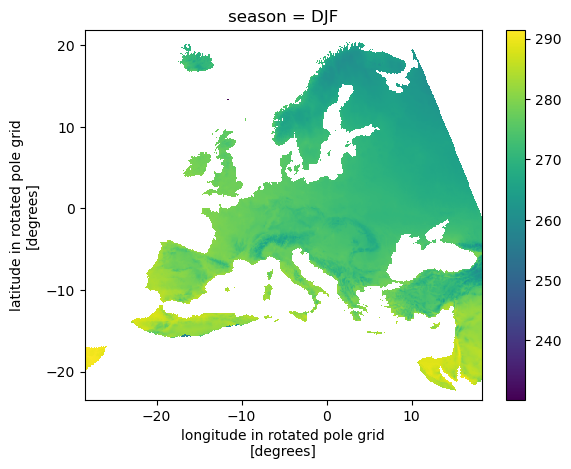

In [16]:
ref_seasmean.isel(season = 0).plot()

# CMIP6

In [17]:
mip_era = "CMIP6"
driving_source_id = "ERA5"

In [ ]:
dsets = open_datasets(
    [variable],
    frequency=frequency,
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

In [ ]:
for k in dsets.keys():
    print(k)
    for var in dsets[k].variables:
        if var in ["orog", "sftlf"]:
            print(var)

In [ ]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period)

In [ ]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [ ]:
for dset in dsets.keys():
    if not check_time(dsets[dset])['continuous']:
        print(f"Time dimension is not continuois for {dset}")

In [ ]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

In [ ]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

In [ ]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [ ]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id", "version_realization"], delimiter = "_"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

In [ ]:
seasonal_bias.to_netcdf(
    f"{save_results_path}/{variable}_{mip_era}_{period.start}-{period.stop}_spatial_bias.nc"
)

# CMIP5

In [29]:
mip_era = "CMIP5"
driving_source_id = "ERAINT"

In [30]:
dsets = open_datasets(
    [variable],
    frequency='mon',
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Opening catalog from https://raw.githubusercontent.com/euro-cordex/joint-evaluation/refs/heads/main/CORDEX-CMIP6.json
Found 11 datasets for variables ['tas']: ['RACMO22E', 'RCA4', 'CCLM4-8-17', 'HadREM3-GA7-05', 'REMO2009', 'REMO2015', 'ALADIN53', 'ALADIN63', 'RegCM4-2', 'COSMO-crCLIM-v1-1', 'ALARO-0']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


decoding dataset CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r0i0p0.COSMO-crCLIM-v1-1.v1.fx.v20191210
Found 22 datasets
decoding dataset CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.fx.v20160112
Found 22 datasets
decoding dataset CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813
Warning for CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813: Variable(s) referenced in cell_measures not in variables: ['areacella']
Warning for CORDEX.EUR-11.GERICS.ERAINT.evaluation.r0i0p0.REMO2015.v1.fx.v20180813: Variable(s) referenced in cell_measures not in variables: ['areacella']
Found 22 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.fx.v20150127
Found 22 datasets
decoding dataset CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127
Found 22 datasets
decoding dataset CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CCLM4-8-17.v1.fx.v20140515
Warning for CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r0i0p0.CC

In [31]:
dsets_day = open_datasets(
    [variable],
    frequency='day',
    source_id = ['WRF381P', 'HIRHAM5', 'RegCM4-6'],
    driving_source_id=driving_source_id,
    mask=True,
    add_missing_bounds=False,
)

Opening catalog from https://raw.githubusercontent.com/euro-cordex/joint-evaluation/refs/heads/main/CORDEX-CMIP6.json
Found 3 datasets for variables ['tas']: ['WRF381P', 'HIRHAM5', 'RegCM4-6']

--> The keys in the returned dictionary of datasets are constructed as follows:
	'project_id.domain_id.institution_id.driving_source_id.driving_experiment_id.driving_variant_label.source_id.version_realization.frequency.version'


/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'sftlf' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'orog' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


decoding dataset CORDEX.EUR-11.DMI.ERAINT.evaluation.r1i1p1.HIRHAM5.v1.fx.v20131119
Found 6 datasets
decoding dataset CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in grid_mapping not in variables: ['rotated_latitude_longitude']
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in bounds not in variables: ['lat_bnds']
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in bounds not in variables: ['lon_bnds']
Warning for CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.fx.v20190919: Variable(s) referenced in grid_mapping not in variables: ['rotated_latitude_longitude']
Found 6 datasets
decoding dataset CORDEX.EUR-11.ICTP.ERAINT.evaluation.r1i1p1.RegCM4-6.v1.fx.v20190502
Found 6 datasets
decoding dataset CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF38

In [32]:
static_vars = ["orog", "sftlf", "areacella", "mask"]
## resample dset_day
dsets_mon = {}
for dset in dsets_day.keys():
    dsets_copy = dsets_day[dset].copy()
    ds_var_mon = dsets_copy[[variable]].resample(time="ME").mean()
    for var in static_vars:
        if var in dsets_copy.variables:
            ds_var_mon[var] = dsets_copy[var]
            
    dsets_mon[dset.replace('.day.', '.mon.')] = ds_var_mon

In [33]:
dsets = dsets | dsets_mon

In [34]:
for k in dsets.keys():
    print(k)
    for var in dsets[k].variables:
        if var in ["orog", "sftlf"]:
            print(var)

CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127
orog
sftlf
CORDEX.EUR-11.MOHC.ERAINT.evaluation.r1i1p1.HadREM3-GA7-05.v1.mon.v20200330
orog
sftlf
CORDEX.EUR-11.GERICS.ERAINT.evaluation.r1i1p1.REMO2015.v1.mon.v20180813
orog
sftlf
CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527
orog
sftlf
CORDEX.EUR-11.MPI-CSC.ERAINT.evaluation.r1i1p1.REMO2009.v1.mon.v20160525
orog
sftlf
CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207
orog
sftlf
CORDEX.EUR-11.CLMcom.ERAINT.evaluation.r1i1p1.CCLM4-8-17.v1.mon.v20140515
orog
sftlf
CORDEX.EUR-11.CLMcom-ETH.ERAINT.evaluation.r1i1p1.COSMO-crCLIM-v1-1.v1.mon.v20191210
orog
sftlf
CORDEX.EUR-11.SMHI.ERAINT.evaluation.r1i1p1.RCA4.v1.mon.v20131026
orog
sftlf
CORDEX.EUR-11.KNMI.ERAINT.evaluation.r1i1p1.RACMO22E.v1.mon.v20140319
orog
sftlf
CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN63.v1.mon.v20191118
orog
sftlf
CORDEX.EUR-11.IPSL.ERAINT.evaluation.r1i1p1.WRF381P.v1.mon.v20190919
orog
sftl

In [35]:
for dset in dsets.keys():
    dsets[dset] = dsets[dset].sel(time=period)

In [36]:
for dset in dsets.keys():
    if not check_equal_period(dsets[dset], period):
        print(f"Temporal coverage of {dset} does not match with {period}")

In [37]:
for dset in dsets.keys():
    if not check_time(ref_on_rotated)['continuous']:
        print(f"Time dimension is not continuois for {dset}")

In [38]:
for dset in dsets.keys():
    dsets[dset] = standardize_unit(dsets[dset], variable)

Convert celsius to kelvin


In [39]:
rotated_grid = create_cordex_grid(domain)
dsets = regrid_dsets(dsets, rotated_grid, method=regridding)

regridding CORDEX.EUR-11.CNRM.ERAINT.evaluation.r1i1p1.ALADIN53.v1.mon.v20150127 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_453x453_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (453, 453) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.DHMZ.ERAINT.evaluation.r1i1p1.RegCM4-2.v1.mon.v20150527 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_551x551_412x424.nc 
Reuse pre-computed weights? False 
Input grid shape:           (551, 551) 
Output grid shape:          (412, 424) 
Periodic in longitude?      False
regridding CORDEX.EUR-11.RMIB-UGent.ERAINT.evaluation.r1i1p1.ALARO-0.v1.mon.v20170207 with grid_mapping: lambert_conformal_conic
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_485x485_4

In [40]:
if variable == "tas":
    for dset in dsets:
        h_c = height_temperature_correction(dsets[dset].orog, ref_on_rotated.elevation)
        dsets[dset]["tas"] = dsets[dset].tas - h_c.fillna(0)

In [41]:
if var_dic[variable]["diff"] == "abs":
    diffs = {
        dset_id: seasonal_mean(ds[[variable]].sel(time=period)).compute()
        - (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
elif var_dic[variable]["diff"] == "rel":
    diffs = {
        dset_id: 100
        * (seasonal_mean(ds[[variable]].sel(time=period)).compute() - (ref_seasmean))
        / (ref_seasmean)
        for dset_id, ds in dsets.items()
        if variable in ds.variables
    }
seasonal_bias = xr.concat(
    list(diffs.values()),
    dim=xr.DataArray(
        list(
            map(
                lambda x: short_iid(x, ["source_id", "version_realization"], delimiter = "_"),
                diffs.keys(),
            )
        ),
        dims="dset_id",
    ),
    compat="override",
    coords="minimal",
)

/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.91 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 10.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/mnt/CORDEX_CMIP6_tmp/user_tmp/jdiezsierra/conda_envs/evaltools/lib/python3.10/site-

In [42]:
seasonal_bias.to_netcdf(
    f"{save_results_path}/{variable}_{mip_era}_{period.start}-{period.stop}_spatial_bias.nc"
)

# Plot

In [43]:
CMIP6_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP6_{period.start}-{period.stop}_spatial_bias.nc"
)
CMIP5_seasonal_bias = xr.open_dataset(
    f"{save_results_path}/{variable}_CMIP5_{period.start}-{period.stop}_spatial_bias.nc"
)

In [44]:
CMIP6_seasonal_bias["dset_id"]

<xarray.DataArray 'dset_id' (dset_id: 1)> Size: 60B
array(['CCLM6-0-1_v1-r1'], dtype='<U15')
Coordinates:
  * dset_id  (dset_id) <U15 60B 'CCLM6-0-1_v1-r1'

In [45]:
eur_colors = pd.read_csv("eurocordex_models.csv")

In [46]:
projects = ["CMIP5", "CMIP6"]
models_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"].apply(
                lambda row: f"{row['model']}_{row['model_version']}", axis=1)
parents_cmip6 = eur_colors[eur_colors["mip_era"] == "CMIP6"].apply(
                lambda row: f"{row['parent']}_{row['parent_version']}", axis=1)
parents_cmip6[
    eur_colors[eur_colors["mip_era"] == "CMIP6"]["parent_mip_era"] == "CMIP6"
] = np.nan

In [47]:
if parent is True:

    parent_str = "parent"
    models = []
    for m5, m6 in zip(parents_cmip6, models_cmip6):
        models.append(f"cmip5_{m5}")
        models.append(f"cmip6_{m6}")
else:

    parent_str = "no-parent"
    models = []
    for m6 in models_cmip6:
        models.append(f"cmip6_{m6}")

models = [m for m in models if "_nan" not in m]
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [48]:
## include 
model = "cmip6_HCLIM43-ALADIN_v1-r1"
new_models = ["cmip5_HIRHAM5_v1", "cmip5_RCA4_v1"]

if model in models:
    idx = models.index(model)
    models[idx+1:idx+1] = new_models
print(models)

['cmip5_ALARO-0_v1', 'cmip6_ALARO1-SFX_v1-r1', 'cmip5_ALADIN63_v1', 'cmip6_CNRM-ALADIN64E1_v1-r1', 'cmip6_HCLIM43-ALADIN_v1-r1', 'cmip5_HIRHAM5_v1', 'cmip5_RCA4_v1', 'cmip5_CCLM4-8-17_v1', 'cmip6_CCLM6-0-1_v1-r1', 'cmip6_CCLM6-0-1-URB_v1-r1', 'cmip6_CCLM6-0-1-URB-ESG_v1-r1', 'cmip6_TSMP1-140-E_NONE', 'cmip6_CCLM5-0-9-NEMOMED12-3-6_NONE', 'cmip6_GCOAST-AHOI1-1_NONE', 'cmip6_GCOAST-AHOIB1-1_NONE', 'cmip6_ICON-CLM-202407-1-1_v1-r1', 'cmip6_GCOAST-AHOI2-1_NONE', 'cmip6_ROAM-NBS_v1-r1', 'cmip5_RegCM4-6_v1', 'cmip6_RegCM5-0_v1-r1', 'cmip5_REMO2015_v1', 'cmip6_REMO2020-2-2_v1-r1', 'cmip6_REMO2020-2-2-iMOVE_v1-r1', 'cmip6_REMO2020-2-2-iMOVE-LUC_v1-r1', 'cmip6_REMO2020-2-2-MR2_v1-r1', 'cmip6_REMO2020-2-2-TEB_v1-r1', 'cmip5_WRF381P_v1', 'cmip6_WRF451Q_v1-r1', 'cmip6_WRF451Q_v1-r2', 'cmip6_WRF451Q_v1-r3', 'cmip5_RACMO22E_v1', 'cmip6_RACMO23E_v1-r1', 'cmip5_HadREM3-GA7-05_v1', 'cmip6_HadREM3-GA7-05_NONE']


In [49]:
models

['cmip5_ALARO-0_v1',
 'cmip6_ALARO1-SFX_v1-r1',
 'cmip5_ALADIN63_v1',
 'cmip6_CNRM-ALADIN64E1_v1-r1',
 'cmip6_HCLIM43-ALADIN_v1-r1',
 'cmip5_HIRHAM5_v1',
 'cmip5_RCA4_v1',
 'cmip5_CCLM4-8-17_v1',
 'cmip6_CCLM6-0-1_v1-r1',
 'cmip6_CCLM6-0-1-URB_v1-r1',
 'cmip6_CCLM6-0-1-URB-ESG_v1-r1',
 'cmip6_TSMP1-140-E_NONE',
 'cmip6_CCLM5-0-9-NEMOMED12-3-6_NONE',
 'cmip6_GCOAST-AHOI1-1_NONE',
 'cmip6_GCOAST-AHOIB1-1_NONE',
 'cmip6_ICON-CLM-202407-1-1_v1-r1',
 'cmip6_GCOAST-AHOI2-1_NONE',
 'cmip6_ROAM-NBS_v1-r1',
 'cmip5_RegCM4-6_v1',
 'cmip6_RegCM5-0_v1-r1',
 'cmip5_REMO2015_v1',
 'cmip6_REMO2020-2-2_v1-r1',
 'cmip6_REMO2020-2-2-iMOVE_v1-r1',
 'cmip6_REMO2020-2-2-iMOVE-LUC_v1-r1',
 'cmip6_REMO2020-2-2-MR2_v1-r1',
 'cmip6_REMO2020-2-2-TEB_v1-r1',
 'cmip5_WRF381P_v1',
 'cmip6_WRF451Q_v1-r1',
 'cmip6_WRF451Q_v1-r2',
 'cmip6_WRF451Q_v1-r3',
 'cmip5_RACMO22E_v1',
 'cmip6_RACMO23E_v1-r1',
 'cmip5_HadREM3-GA7-05_v1',
 'cmip6_HadREM3-GA7-05_NONE']

In [50]:
seen = set()
models = [m for m in models if not (m in seen or seen.add(m))]

In [51]:
models_all = ["e-obs"] + obs_seasonal_bias.dset_id.values.tolist() + models

/tmp/ipykernel_2074086/2507981193.py:3: FutureWarning: This is a FutureWarning example
  warnings.warn("This is a FutureWarning example", FutureWarning)
/tmp/ipykernel_2074086/2507981193.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_2074086/2507981193.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_2074086/2507981193.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)
/tmp/ipykernel_2074086/2507981193.py:168: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)


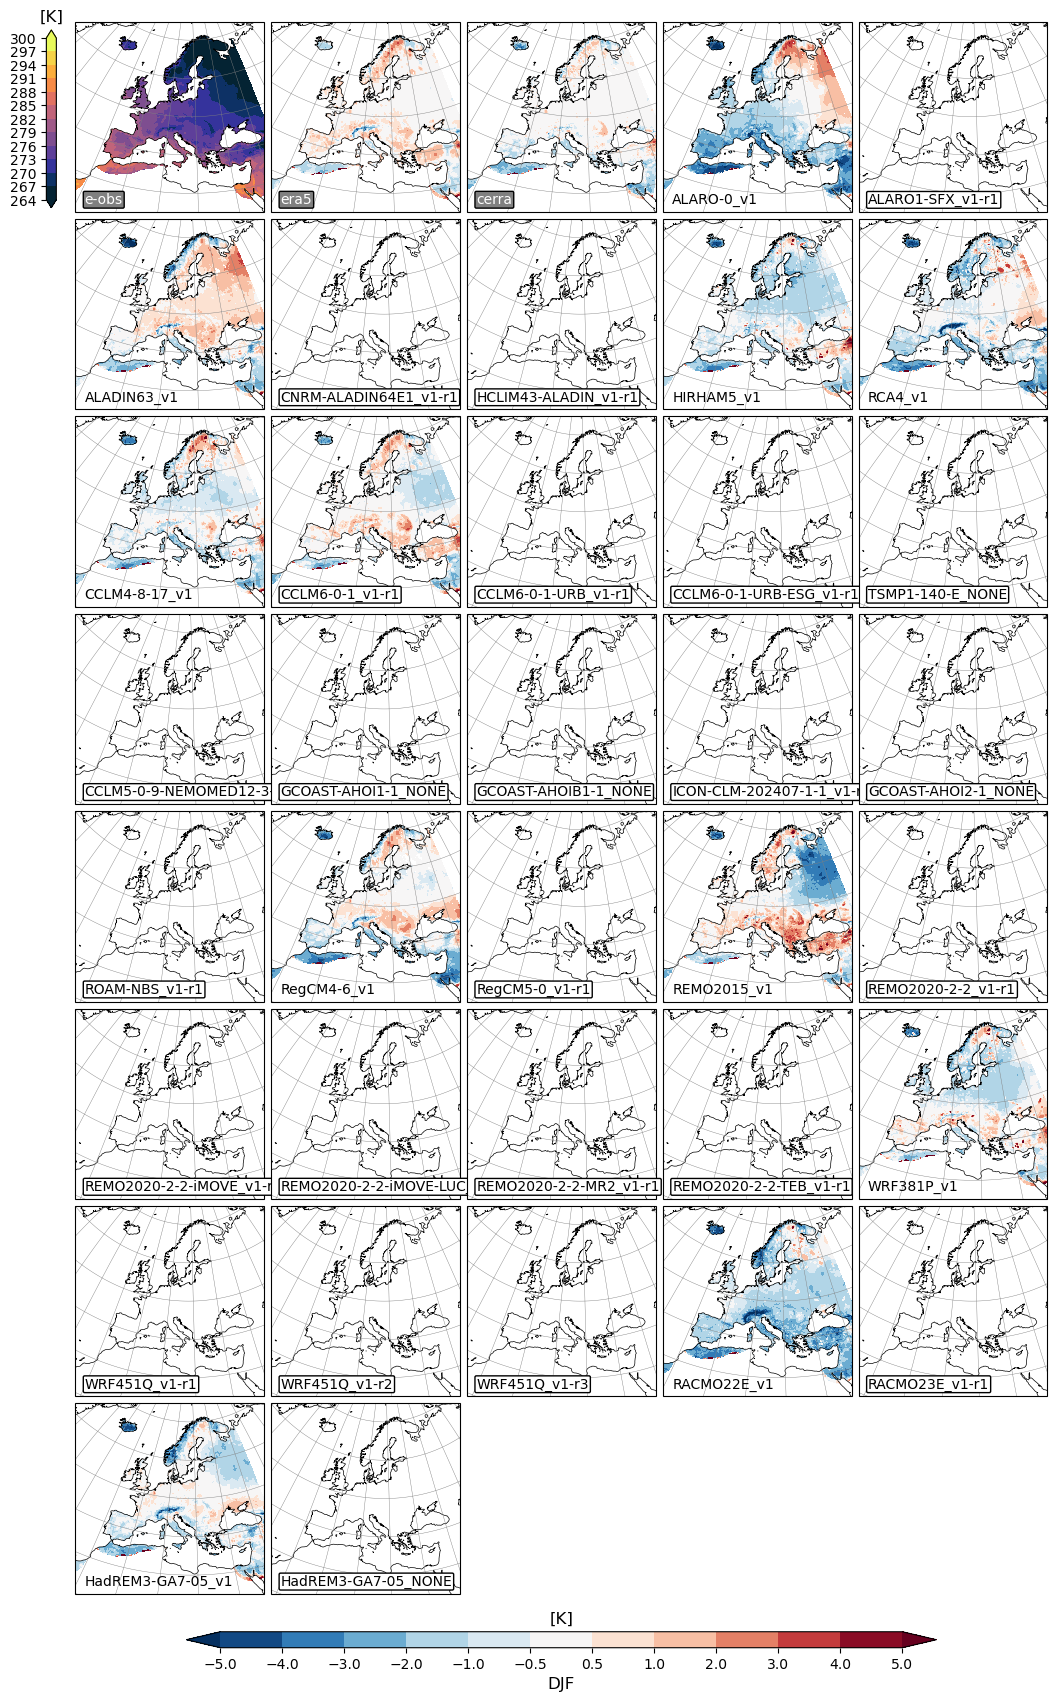

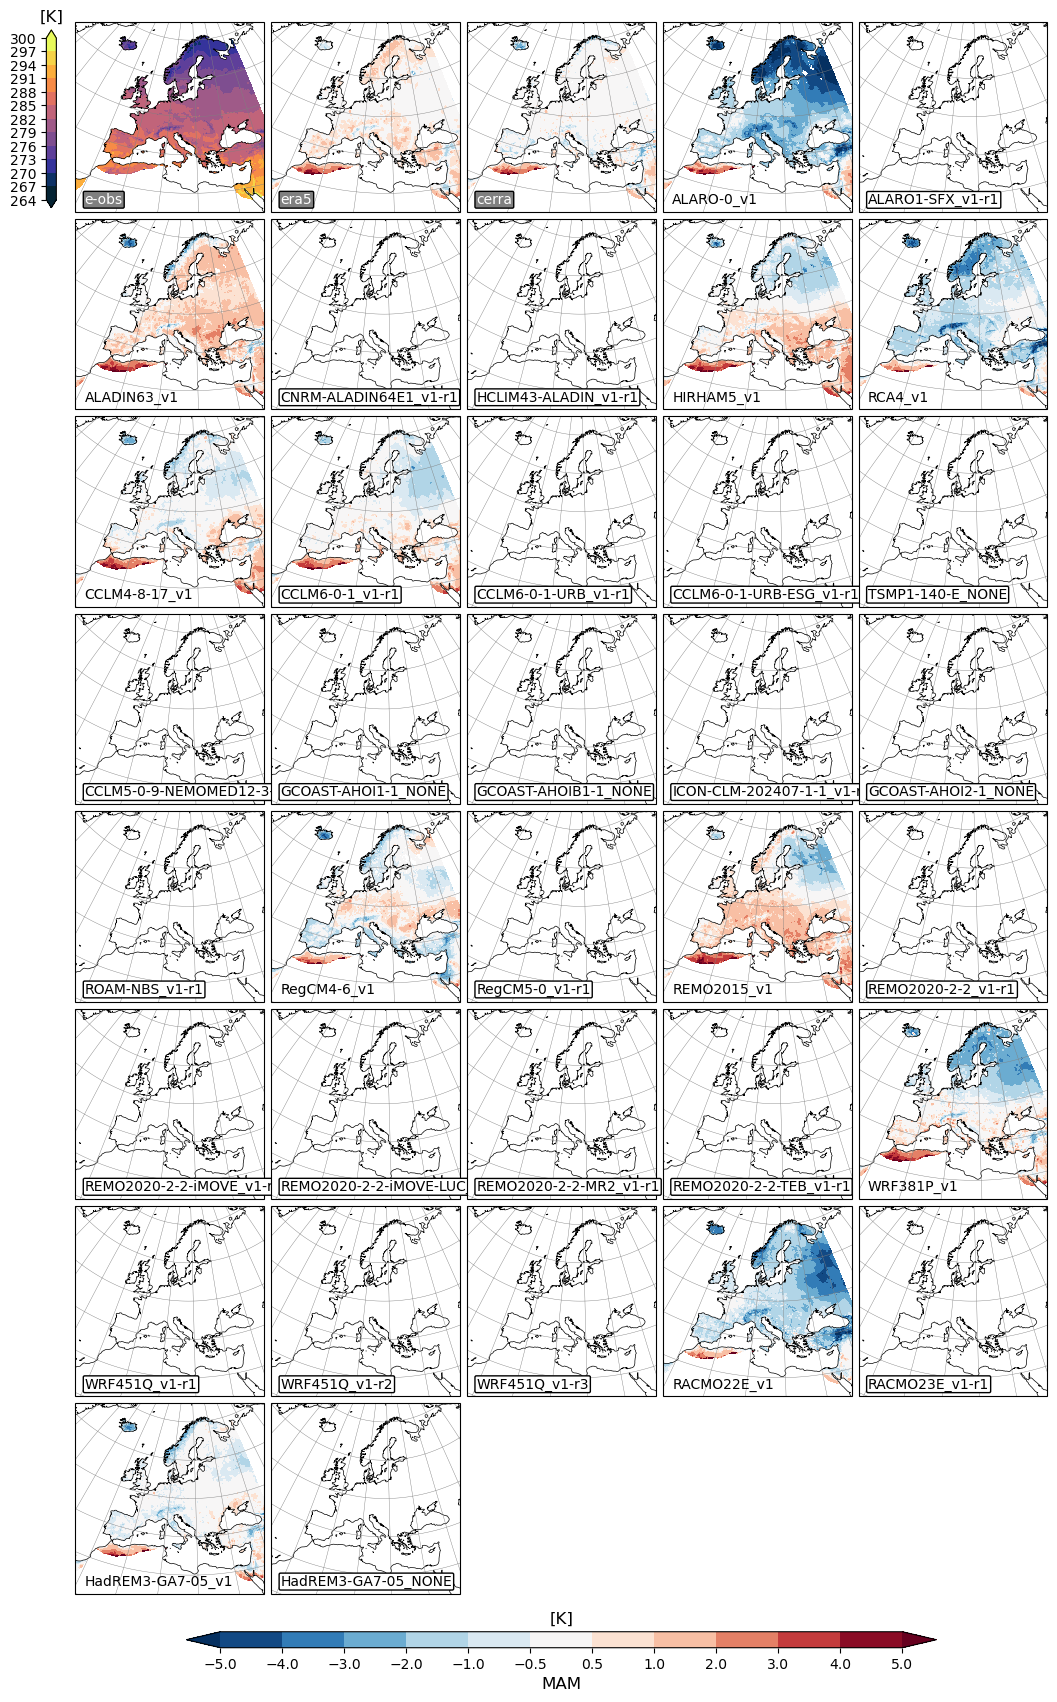

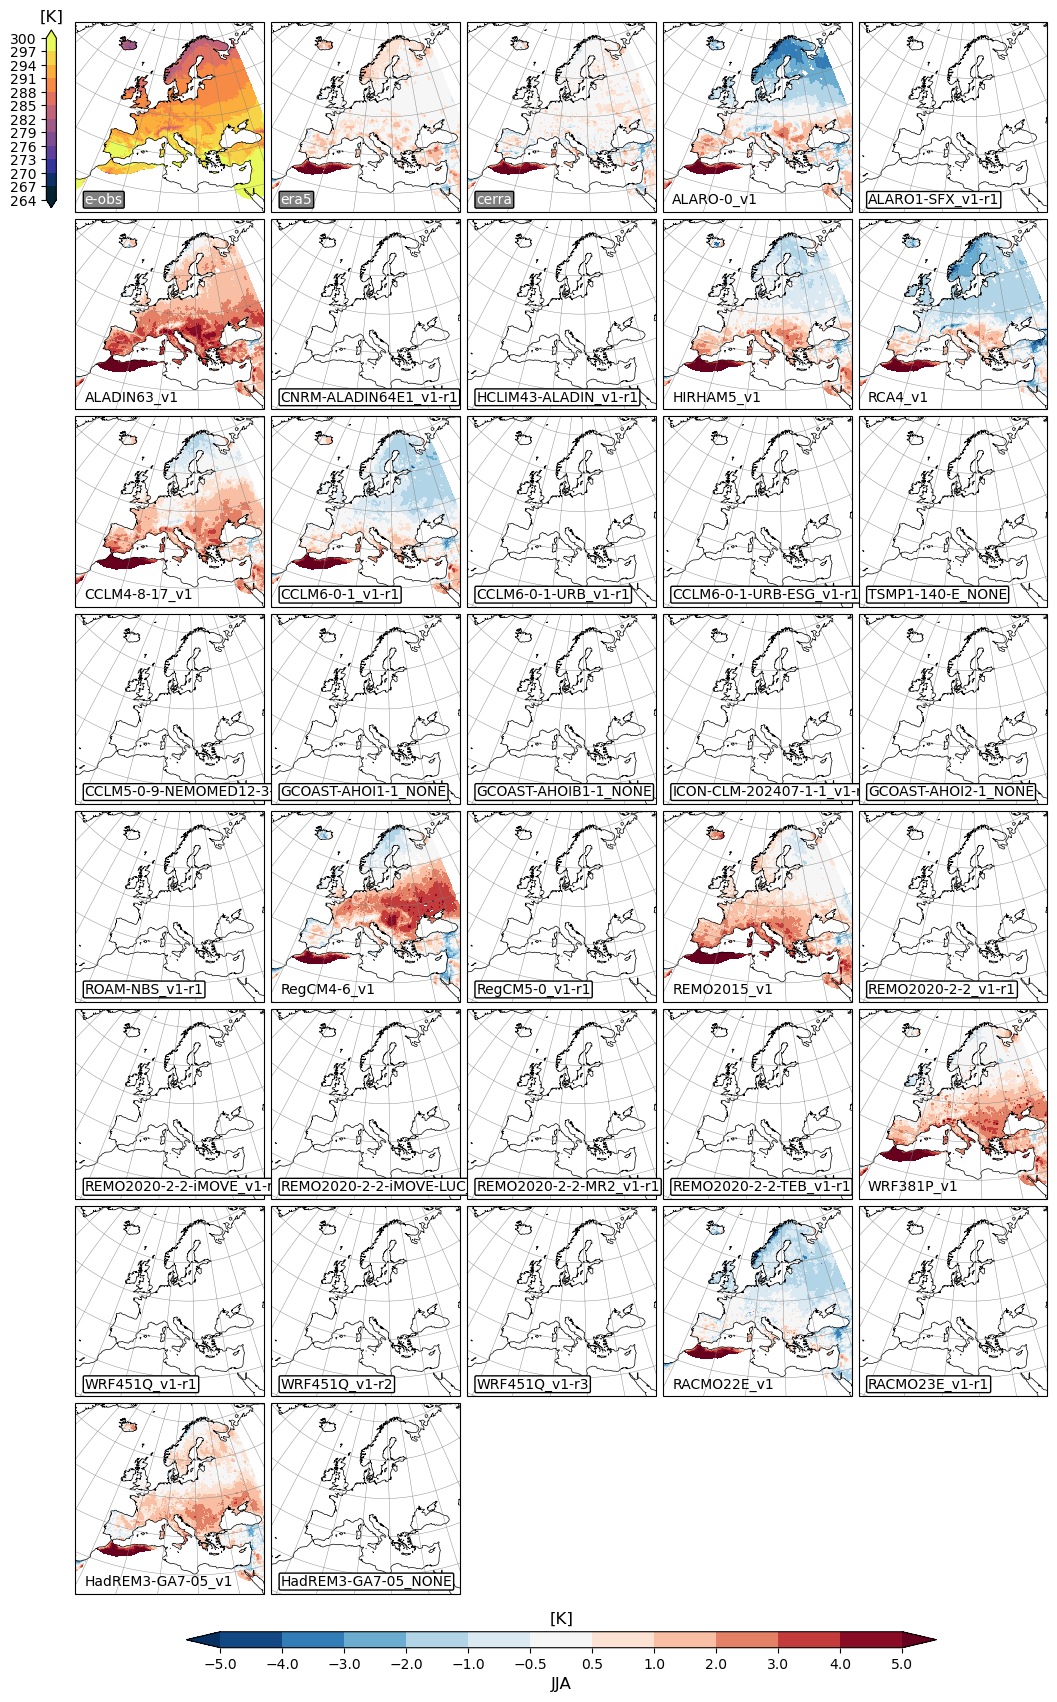

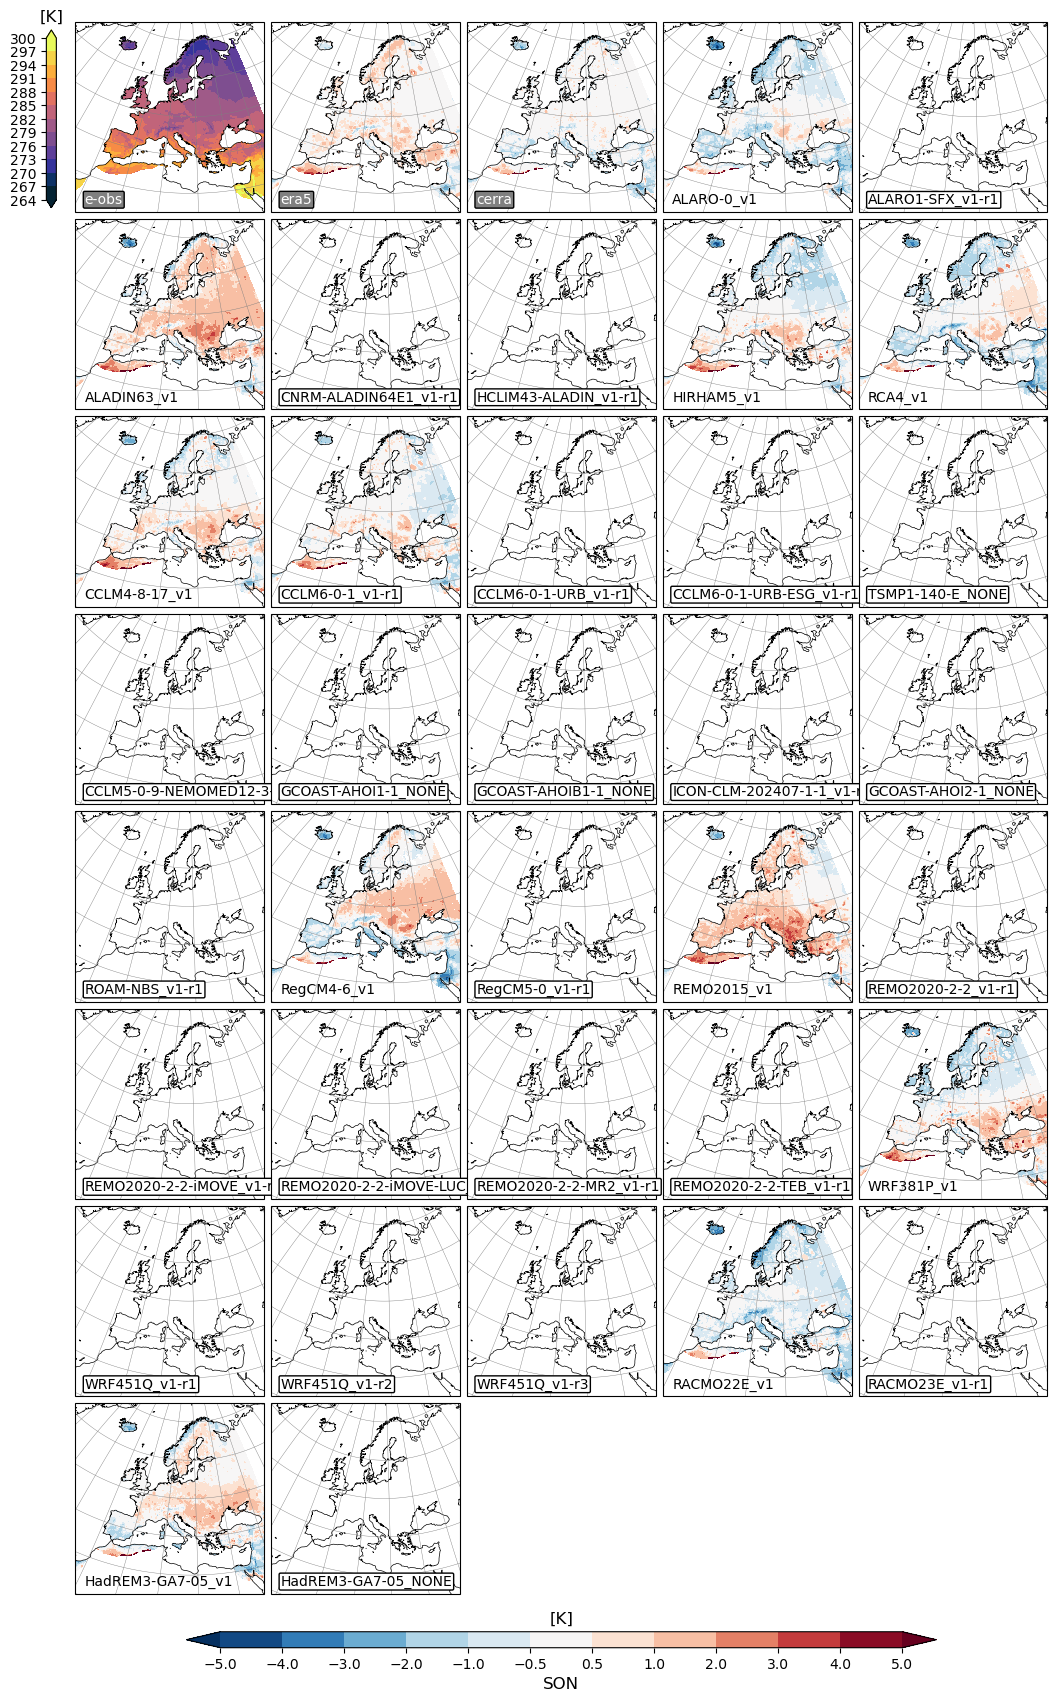

In [52]:
import warnings

warnings.warn("This is a FutureWarning example", FutureWarning)

for season in ["DJF", "MAM", "JJA", "SON"]:

    ncols = 5
    nrows = math.ceil(len(models_all) / ncols)
    transform = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162.0)
    projection = transform

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": projection},
        figsize=(ncols * 2, nrows * 2),
    )

    axs = axs.flatten()

    for n_m, model in enumerate(models_all):

        levels = var_dic[variable]["levels"]
        cmap = var_dic[variable]["cmap"]

        if "cmip5" in model:
            ds = CMIP5_seasonal_bias
            project = "cmip5"
            model = model.split(project + "_")[1]
        elif "cmip6" in model:
            ds = CMIP6_seasonal_bias
            project = "cmip6"
            model = model.split(project + "_")[1]
        elif "e-obs" == model:
            ds = ref_seasmean
            project = "e-obs"
            model = project
        else:
            ds = obs_seasonal_bias
            project = "obs"

        aspect = ds.cf.sizes["Y"] / ds.cf.sizes["X"]

        if project in ["obs", "cmip6", "cmip5"]:
            if model in ds.dset_id:
                data = (
                    ds[variable]
                    .isel(
                        season=np.where(ds.season == season)[0],
                        dset_id=np.where(ds.dset_id == model)[0],
                    )
                    .squeeze(dim=["season", "dset_id"])
                )
                cs = axs[n_m].contourf(
                    ds.cf["X"],
                    ds.cf["Y"],
                    data,
                    transform=transform,
                    levels=levels,
                    extend="both",
                    cmap=cmap,
                )
            else:
                cs = axs[n_m].contourf(
                    ds.cf["X"],
                    ds.cf["Y"],
                    data * np.nan,
                    transform=transform,
                    levels=levels,
                    extend="both",
                    cmap=cmap,
                )

        elif project == "e-obs":
            data = ds.isel(season=np.where(ds.season == season)[0]).squeeze(
                dim=["season"]
            )

            n_colors = len(e_obs_dic[variable]["levels"]) - 1
            # cmap_eobs = plt.get_cmap(e_obs_dic[variable]["cmap"], n_colors)
            if variable == "pr":
                data = data * 30.5
            colors = e_obs_dic[variable]["cmap"](np.linspace(0, 1, n_colors))
            cmap_eobs = mcolors.ListedColormap(colors)
            norm = BoundaryNorm(e_obs_dic[variable]["levels"], ncolors=n_colors)
            c1 = axs[n_m].contourf(
                ds.cf["X"],
                ds.cf["Y"],
                data,
                transform=transform,
                levels=e_obs_dic[variable]["levels"],
                extend="both",
                cmap=cmap_eobs,
                norm=norm,
            )

        axs[n_m].set_aspect(round(aspect, 3))
        axs[n_m].coastlines(resolution="50m", color="black", linewidth=0.5)

        gl = axs[n_m].gridlines(
            draw_labels=False,
            linewidth=0.3,
            color="gray",
            xlocs=range(-180, 180, 10),
            ylocs=range(-90, 90, 10),
        )

        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        axs[n_m].xaxis.set_major_formatter(lon_formatter)
        axs[n_m].yaxis.set_major_formatter(lat_formatter)

        if project == "cmip6":
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                bbox=dict(
                    facecolor="white", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )
        elif project == "cmip5":
            axs[n_m].set_title(model, loc="left", y=0, x=0.05, fontsize=10)
        elif project in ["obs", "e-obs"]:
            axs[n_m].set_title(
                model,
                loc="left",
                y=0,
                x=0.05,
                fontsize=10,
                color="white",
                bbox=dict(
                    facecolor="grey", edgecolor="black", boxstyle="round,pad=0.1"
                ),
            )

    cb1_ax = fig.add_axes([-0.015, 1 - (1 / nrows), 0.01, 1 / (nrows + 1)])
    cb1 = fig.colorbar(
        c1,
        cax=cb1_ax,
        ax=axs[0],
        orientation="vertical",
        location="left",
        ticks=e_obs_dic[variable]["levels"],
        spacing="uniform",
    )
    cb1.ax.set_yticklabels(
        [str(lev) for lev in e_obs_dic[variable]["levels"]]
    )  # opcional: etiquetas como texto
    cb1.ax.tick_params(labelsize=10)
    cb1_ax.set_title(f"[{e_obs_dic[variable]['units']}]", fontsize=12)

    cbar_ax = fig.add_axes([0.125, -0.025, 0.75, 0.01])
    cbar = fig.colorbar(cs, cax=cbar_ax, orientation="horizontal", ticks=levels)
    cbar_ax.set_title(f"[{var_dic[variable]['units']}]", fontsize=12)
    cbar.ax.yaxis.set_ticks_position("left")
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label(season, fontsize=12)

    for ax in axs[len(models_all) :]:
        ax.remove()

    for ax in axs:
        ax.set_aspect("auto")

    plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

    plt.savefig(
        f"{save_figure_path}/CMIP6-{parent_str}_eobs_{variable}_{season}_{period.start}-{period.stop}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{save_figure_path}/CMIP6-{parent_str}_eobs_{variable}_{season}_{period.start}-{period.stop}.pdf",
        bbox_inches="tight",
    )